# Saltwater Intrusion: case study for Ameland

<div>
<img src="../data/ameland.jpg" width="500"/>
<img src="../data/ameland_map.png" width="514">
</div>

This notebook is a conceptual 2D study of saltwater intrusion effects of hypothetical island with the topology of Ameland.
The stresses driving the simulation are freshwater recharge (RCH) from precipitation on the island, and the sea boundary 
that is accounted for using general head boundary cells (GHB). The location and values of boundary elements is given
with sealevel as a parameter, such that effects of sealevel rise can be studied.

## Outline
* Process elevation data for topology
* Set up varying boundaries for rising sea level
* Create the FloPy model GWF-GWT with the buoyancy package for density dependent flow
* Run and plot results

In [16]:
import flopy

import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [36]:
# Put the name of the mf6 executable into mf6exe.txt,
# which is not under version control.
with open(pl.Path("./mf6exe.txt"), "r") as f:
    mf6exe = f.readline().strip()
print(f"using executable: {mf6exe}")

using executable: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


This exercise is about sealevel rise, you can change the projection here:

In [2]:
init_sealevel = -0.9
rise_per_period = 0.1

Here we load the pre-processed cross section data from file. 

(As a matter of fact, it was taken from the database here https://www.ahn.nl/eerste-deel-van-ahn-5-is-beschikbaar
and subsequently extracted from the TIFs using QGIS.)

In [4]:
# load 
arr = np.loadtxt("../data/ameland.dat")
x = arr[:,0]
y = arr[:,1]

# resample
length = np.amax(x) - np.amin(x)
nsamples = 41
xc = np.linspace(np.amin(x), np.amax(x), nsamples)
top = np.interp(xc, x, y)

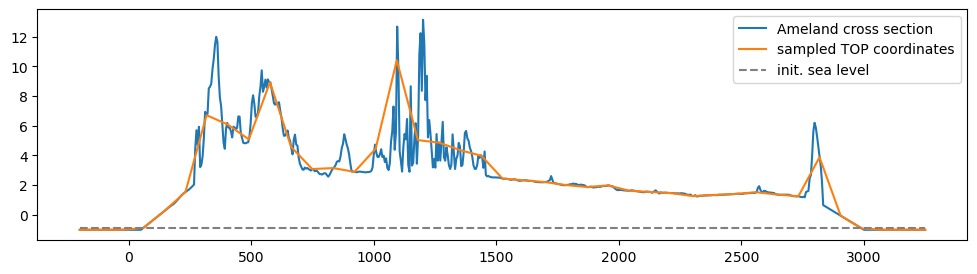

In [5]:
plt.figure(figsize=(12,3))
plt.plot(x, y, label="Ameland cross section")
plt.plot(xc, top, label="sampled TOP coordinates")
plt.hlines(init_sealevel, np.amin(x), np.amax(x), 
           linestyles="dashed", color="grey", 
           label="init. sea level")
_ = plt.legend()

### Time data
Here you set up the time data for the TDIS package. The first period will have the initial seal level as a boundary stress, and then multiple stress periods will follow to account for the rise.

In [6]:
nper = 21
year = 365.25
dtmin = 1.0
dt = 5 * year

duration = 500 * year # days
nsteps = duration / dt
period_data = [(duration, nsteps, 1.0)]

duration = 10 * year
nsteps = duration / dt
for iper in range(1,nper):
    period_data.append((duration, nsteps, 1.0))

### Input for the discretization package (DIS)
The top layer will have a varying cell height resulting from the island topology. Deeper layers are modeled with equal dimensions.

In [7]:
nlay = 16
nrow = 1
ncol = nsamples
delr = delc = length/ncol

topc = np.zeros((nlay, nrow, ncol), dtype=float)
botm = np.zeros((nlay, nrow, ncol), dtype=float)

dz = 160.0/nlay
topc[0] = top.reshape((nrow,ncol))
botm[0] = -5.0
for ilay in range(1, nlay):
    botm[ilay] = botm[ilay - 1] - dz
    topc[ilay] = topc[ilay - 1] - dz

### Other parameters and helper functions

In [8]:
porosity = spec_yield = 0.35 # which is neglecting specific retention 

conc_fresh = 0.0
conc_sea = 35.0
conc_limit = 20e-03 # 20 milligrams/liter for potable water

rch_rate = 0.001 # m/d

This function gives the sea level projection for each stress period number (`iper`)

In [9]:
def get_sea_level(iper):
  return init_sealevel + iper * rise_per_period

The sea water will cover increasingly more of the island when it is rising. The following function determines which columns are flooded, so they can be equipped with the appropriate GHB boundaries, but also the ones that aren't, for applying the recharge (RCHA) boundary condition.

In [10]:
def get_flooded_cols(sea_level):
  flooded_cols = []
  for icol in range(ncol):
      if sea_level > topc[0, 0, icol]:
          flooded_cols.append(icol)
      else: break
  for icol in reversed(range(ncol)):
      if sea_level > topc[0, 0, icol]:
          flooded_cols.append(icol)
      else: break
    
  return flooded_cols

## Set up the FloPy model

In [ ]:
sim_ws = pl.Path("./temp/case7buy")
sim_ws.mkdir(exist_ok=True)

sim_name = "ameland"
gwt_name = "gwt"
gwf_name = "gwf"

sim = flopy.mf6.MFSimulation(
    sim_ws=sim_ws,
    exe_name=mf6exe,
)

### Adaptive Timestepping and TDIS
Here we apply a relatively recent feature: adaptive timestepping control (ATS) to the TDIS package. This, together with the `ats_percel` parameter in the advection package below, will help restricting the timesteps to follow a Courant-type criterion and will prevent oscillations and disturbances of the simulated solute concentration.

In [38]:
tdis = flopy.mf6.ModflowTdis(sim, 
                             nper=nper, 
                             perioddata=period_data)
ats_filerecord = sim_name + ".ats"
atsperiod = [
    (iper, dtmin, dtmin, dt, 2.0, 2.0) for iper in range(nper)
]
tdis.ats.initialize(
    maxats=len(atsperiod),
    perioddata=atsperiod,
    filename=ats_filerecord,
)

The numerical solver data for the GWF solution:

In [39]:
imsgwf = flopy.mf6.ModflowIms(
    sim,
    complexity="complex",
    print_option="SUMMARY",
    linear_acceleration="bicgstab",
    outer_maximum=100,
    inner_maximum=100,
    outer_dvclose=1e-4,
    inner_dvclose=1e-5,
)

## The GWF model

In [40]:
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=gwf_name,
    print_input=False,
    save_flows=True, 
    newtonoptions="NEWTON UNDER_RELAXATION",
)

# spatial discretization: regular grid DIS
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=topc[0],
    botm=botm,
    idomain=1,
    filename=f"{gwf_name}.dis",
)

We start with the heads set to the initial sea level:

In [41]:
# initial conditions IC
strt = init_sealevel
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)

# the flow package NPF
hk = 10.0
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    icelltype=1,
    k=hk,
)

The Buoyancy package will account for the density effects from varying salt concentration on the flow solution:

In [42]:
# configure the Buoyancy Package BUY
pd = [(0, 0.7, 0.0, gwt_name, "concentration")]
flopy.mf6.ModflowGwfbuy(
    gwf, 
    packagedata=pd
)

# storage
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=1,
    ss=0.00001,
    sy=spec_yield,
    transient={0 : True},
)

We apply an array with recharge to the top of the model. This recharge is the source of fresh water in the model. But the columns that are flooded with sea water (which changes over the stress periods) will receive no recharge.

In [43]:
rch_pkg = "rch_package"
rch_spd = {}
for iper in range(nper):
    sea_level = get_sea_level(iper)
    flooded_cols = get_flooded_cols(sea_level)
    recharge = np.ones((nrow,ncol), dtype=float) * rch_rate
    recharge[0, flooded_cols] = 0.0
    rch_spd[iper] = recharge

# recharge array package   
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=rch_spd,
    auxiliary="CONCENTRATION",
    aux={0 : conc_fresh},
    pname=rch_pkg,
)

There are GHB cells in the model aligned vertically along the sides, as well as on the top of columns that are flooded. It is important set the auxiliary "ELEVATION" parameter for the latter because on default the nodal elevation is used, which is not correct. If you want the details on this, have a look at this paper: https://ngwa.onlinelibrary.wiley.com/doi/abs/10.1111/gwat.12967

In [44]:
ghb_pkg = "ghb_package"
ghb_spd = {}
for iper in range(nper):

    ghb_data = []
    sea_level = get_sea_level(iper)
    flooded_cols = get_flooded_cols(sea_level)

    # top GHBs
    for icol in flooded_cols:
        elev = topc[0, 0, icol] # top elevation
        area = delr * delc
        cell_height = topc[0, 0, icol] - botm[0, 0, icol]
        cond = hk * area / (0.5 * cell_height)
        ghb_data.append([(0, 0, icol), sea_level, cond, conc_sea, elev])
    # side GHBs
    for ilay in range(nlay):
        elev = 0.5 * (topc[ilay, 0, 0] + botm[ilay, 0, 0]) # node elevation
        area = delc * (topc[ilay, 0, 0] - botm[ilay, 0, 0])
        cond = hk * area / (0.5 * delr)
        ghb_data.append([(ilay, 0, 0), sea_level, cond, conc_sea, elev])
    for ilay in range(nlay):
        elev = 0.5 * (topc[ilay, 0, 0] + botm[ilay, 0, 0]) # node elevation
        area = delc * (topc[ilay, 0, ncol - 1] - botm[ilay, 0, ncol - 1])
        cond = hk * area / (0.5 * delr)
        ghb_data.append([(ilay, 0, ncol - 1), sea_level, cond, conc_sea, elev])
    
    ghb_spd[iper] = ghb_data

# the general head boundary package
ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    maxbound=len(ghb_spd),
    auxiliary=["CONCENTRATION","ELEVATION"],
    stress_period_data=ghb_spd,
    pname=ghb_pkg,
)

The top cells that are not flooded are equipped with a drain which gives the water a chance to leave the system:

In [45]:
drn_pkg = "drn_package"
drn_spd = {}
for iper in range(nper):
    drn_data = []
    sea_level = get_sea_level(iper)
    flooded_cols = get_flooded_cols(sea_level)

    for icol in range(ncol):
        if icol in flooded_cols: continue
        cell_height = topc[0, 0, icol] - botm[0, 0, icol]
        area = delr * delc
        cond = hk * area / (0.5 * cell_height)  # kv / b
        drn_data.append([(0, 0, icol), topc[0, 0, icol], cond])
    
    drn_spd[iper] = drn_data

# drains
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    maxbound=len(drn_spd),
    stress_period_data=drn_spd,
    pname=drn_pkg,
)

In [46]:
# output control
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwf.name}.hds",
    budget_filerecord=f"{gwf.name}.cbc",
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("BUDGET", "LAST")],
)

# match model with numerical solution
sim.register_ims_package(imsgwf, [gwf_name])

## The GWT model

In [47]:
gwt = flopy.mf6.ModflowGwt(
        sim,
        modelname=gwt_name,
        print_input=False,
        save_flows=True,
)

# DIS: same grid as flow
dis = flopy.mf6.ModflowGwtdis(
    gwt,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    idomain=1,
    top=topc[0],
    botm=botm,
)

The model is completely salt at first, so the freshwater recharge has to drive away the salt to build up a lense

In [48]:
conc_start = conc_sea
# initial conditions
ic = flopy.mf6.ModflowGwtic(gwt, strt=conc_start, filename=f"{gwt_name}.ic")

Note that the advection package has the `ats_percel` parameter, discussed earlier:

In [49]:
# advection
adv = flopy.mf6.ModflowGwtadv(
  gwt, 
  scheme="tvd",
  ats_percel=0.7,
  filename=f"{gwt_name}.adv")

In [50]:
diffc = 0.0
alphal = 0.1
# dispersion package
dsp = flopy.mf6.ModflowGwtdsp(
    gwt,
    diffc=diffc,
    alh=alphal,
    alv=alphal,
    ath1=0.0,
    atv=0.0,
    filename=f"{gwt_name}.dsp",
)

The Mobile Storage and Transfer (MST) Package of the GWT Model for MODFLOW 6 represents solute
mass storage, sorption, and first- or zero-order decay:

In [51]:
# mobile storage
mst = flopy.mf6.ModflowGwtmst(
    gwt, 
    porosity=porosity,
    filename=f"{gwt_name}.mst"
)

Flow model source and sink mixing:

In [52]:
sourcerecarray = [
    (rch_pkg, "AUX", "CONCENTRATION"),
    (ghb_pkg, "AUX", "CONCENTRATION")
]
ssm = flopy.mf6.ModflowGwtssm(
    gwt, sources=sourcerecarray, filename=f"{gwt_name}.ssm"
)

In [53]:
# output control
oc = flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord=f"{gwt_name}.cbc",
    concentration_filerecord=f"{gwt_name}.ucn",
    saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
)

# numerical solution for the solute transport
imsgwt = flopy.mf6.ModflowIms(
        sim,
        complexity="complex",
        print_option="SUMMARY",
        linear_acceleration="bicgstab",
        outer_maximum=1000,
        inner_maximum=100,
        outer_dvclose=1e-4,
        inner_dvclose=1e-5,
        filename=f"{gwt_name}.ims",
    )

# match transport model with the solution
sim.register_ims_package(imsgwt, [gwt_name])

The flow model needs to be coupled to its transport counterpart through an Exchange:

In [54]:
gwfgwt = flopy.mf6.ModflowGwfgwt(
    sim,
    exgtype="GWF6-GWT6",
    exgmnamea=gwf_name,
    exgmnameb=gwt_name,
    filename="gwfgwt.exg",
)

Note: the following command will produce quite a bit of output. You can also enable it and limit this in Jupyter Lab by right clicking on output cell and selecting **Enable Scrolling for Outputs**. Or simply set the silent flags to False.

In [56]:
sim.write_simulation(silent=False)
success, text = sim.run_simulation(silent=False)
if not success:
  raise ValueError(f"Simulation failed")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing package ameland.ats...
  writing package gwfgwt.exg...
  writing model gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package buy...
    writing package sto...
    writing package rch_package...
    writing package ghb_package...
    writing package drn_package...
    writing package oc...
  writing model gwt...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
    

### Plot the water table on the terrain

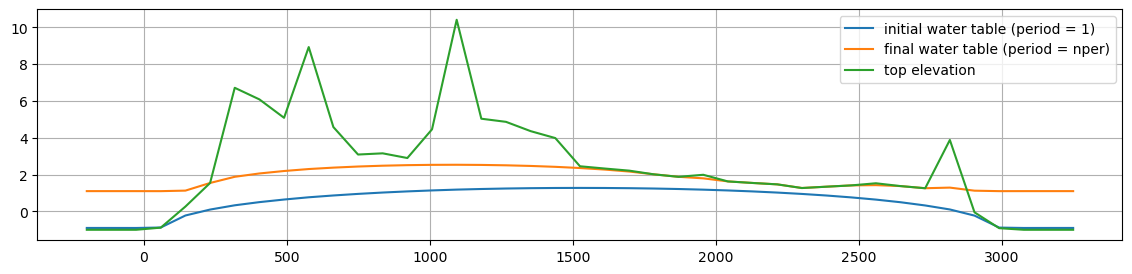

In [57]:
times = gwf.output.head().get_times()
head_first = gwf.output.head().get_data(totim=times[0])
head_last = gwf.output.head().get_data(totim=times[-1])
wt_first = flopy.utils.postprocessing.get_water_table(head_first)
wt_last = flopy.utils.postprocessing.get_water_table(head_last)

fig = plt.figure(figsize=(14,3))
plt.plot(xc, wt_first, label="initial water table (period = 1)")
plt.plot(xc, wt_last, label="final water table (period = nper)")
plt.plot(xc, top, label="top elevation")
plt.grid()
plt.legend()

A function to come up with an estimate for the volume of potable water in the aquifer:

In [58]:
# returns 'volume' in m^2 (volume per meter along the y-axis)
def get_potable_volume(conc, limit):
  potable_volume = 0.0
  for ilay in range(nlay):
    for icol in range(ncol):
        if conc[ilay, 0, icol] < limit:
          vol = porosity * delr * 1.0 * (topc[ilay, 0, icol] - botm[ilay, 0, icol])
          potable_volume += vol
  return potable_volume

## Final result: head and concentration as a result of sea level rise

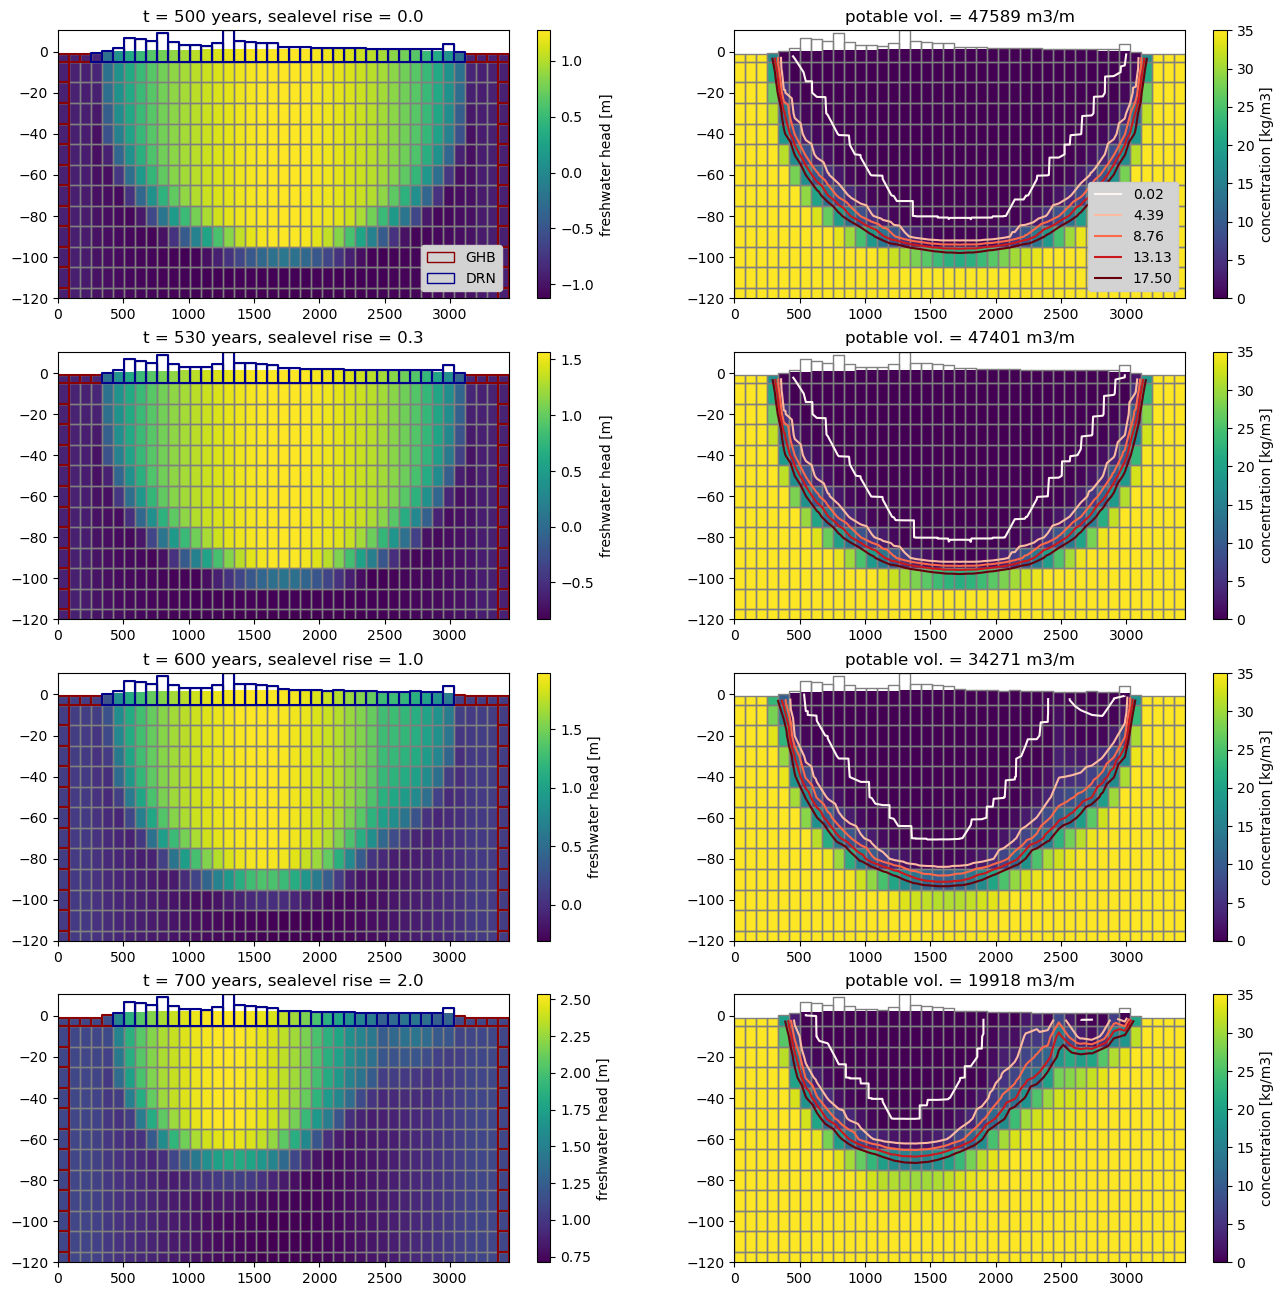

In [59]:
plot_periods = [0, 3, int(nper/2), nper - 1]
nr_plots = len(plot_periods)

fig, axs = plt.subplots(len(plot_periods), 2, figsize=(16, 4 * nr_plots))
for idx, iper in enumerate(plot_periods):
  head = gwf.output.head().get_data(totim=times[iper])
  conc = gwt.output.concentration().get_data(totim=times[iper])

  # plot heads and location of boundary conditions
  ax = axs[idx, 0]
  t_yrs = int(0.1 + times[iper]/365.25)
  csl_m = get_sea_level(iper) - init_sealevel
  ax.set_title(f"t = {t_yrs} years, sealevel rise = {csl_m:.1f}")
  pxs = flopy.plot.PlotCrossSection(model=gwf, line={"row": 0}, ax=ax)
  pa = pxs.plot_array(head, head=head)
  pxs.plot_grid()
  pc_ghb = pxs.plot_bc("GHB", ec="darkred", fc='none', lw=1.5, label="GHB", kper=iper)
  pxs.plot_bc("DRN", ec="darkblue", fc='none', lw=1.5,label="DRN", kper=iper)
  handles = [Polygon([(0,0), (10,0), (0,-10)], fc='none', color="darkred", label="GHB"),
             Polygon([(0,0), (10,0), (0,-10)], fc='none', color="darkblue", label="DRN")]
  cb = plt.colorbar(pa)
  cb.set_label("freshwater head [m]")
  ax.set_ylim(-120,)
  if idx == 0:
    ax.legend(handles=handles, loc="lower right", facecolor='lightgrey', framealpha=1)

  # plot concentration and contours
  ax = axs[idx, 1]
  ax.set_title(f"potable vol. = {int(get_potable_volume(conc, conc_limit))} m3/m")
  pxs = flopy.plot.PlotCrossSection(model=gwt, line={"row": 0}, ax=ax)
  pa = pxs.plot_array(conc, head=head)
  nr_levels = 5
  levels = np.linspace(conc_limit, conc_sea/2.0, nr_levels)
  cs = pxs.contour_array(conc, levels=levels, cmap="Reds")
  handles, labels = cs.legend_elements()
  pxs.plot_grid()
  cb = plt.colorbar(pa)
  cb.set_label("concentration [kg/m3]")
  ax.set_ylim(-120,)
  if idx == 0:
    ax.legend(handles, 
                    [f"{levels[i]:.2f}" for i in range(nr_levels)], 
                    loc='lower right',facecolor='lightgrey', framealpha=1)


## Set up a MODFLOW 6 Model using SWI

In [108]:
sim_ws = pl.Path("./temp/case7swi")
sim_ws.mkdir(exist_ok=True)

sim_name = "ameland"
gwf_name = "gwf"

sim = flopy.mf6.MFSimulation(
    sim_ws=sim_ws,
    exe_name=mf6exe,
)

In [109]:
tdis = flopy.mf6.ModflowTdis(sim, 
                             nper=nper, 
                             perioddata=period_data)

In [110]:
imsgwf = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    linear_acceleration="bicgstab",
    outer_maximum=100,
    inner_maximum=100,
    outer_dvclose=1e-4,
    inner_dvclose=1e-5,
)

## The GWF model

In [111]:
# for swi set nlay to 1
nlay = 1

In [112]:
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=gwf_name,
    print_input=False,
    save_flows=True, 
    newtonoptions="NEWTON UNDER_RELAXATION",
)

# spatial discretization: regular grid DIS
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=topc[0],
    botm=botm[-1],
    idomain=1,
    filename=f"{gwf_name}.dis",
)

In [113]:
# initial conditions IC
strt = init_sealevel
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)

# the flow package NPF
hk = 10.0
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    icelltype=1,
    k=hk,
)

In [114]:
# configure the swi package
zeta_file = gwf_name + ".zta"
swi = flopy.mf6.ModflowGwfswi(
    gwf, 
    zeta_filerecord=zeta_file,
    tva6_filerecord=f"{gwf_name}.swi.tva",
    zetastrt=-10,
)

# initialize the tva subpackage with the saltwater head
aux = {}
for kper in range(nper):
    sea_level = get_sea_level(kper)
    aux[kper] = [sea_level]
swi.tva.initialize(auxiliary=["saltwater_head"], aux=aux)


In [115]:
# storage
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=1,
    ss=0.00001,
    sy=spec_yield,
    transient={0 : True},
)

In [116]:
rch_pkg = "rch_package"
rch_spd = {}
for iper in range(nper):
    sea_level = get_sea_level(iper)
    flooded_cols = get_flooded_cols(sea_level)
    recharge = np.ones((nrow,ncol), dtype=float) * rch_rate
    recharge[0, flooded_cols] = 0.0
    rch_spd[iper] = recharge

# recharge array package   
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=rch_spd,
    auxiliary="CONCENTRATION",
    aux={0 : conc_fresh},
    pname=rch_pkg,
)

In [117]:
for iper in range(nper):

    sea_level = get_sea_level(iper)
    flooded_cols = get_flooded_cols(sea_level)
    print(sea_level, flooded_cols)

-0.9 [0, 1, 2, 40, 39, 38, 37]
-0.8 [0, 1, 2, 3, 40, 39, 38, 37]
-0.7 [0, 1, 2, 3, 40, 39, 38, 37]
-0.6 [0, 1, 2, 3, 40, 39, 38, 37]
-0.5 [0, 1, 2, 3, 40, 39, 38, 37]
-0.4 [0, 1, 2, 3, 40, 39, 38, 37]
-0.29999999999999993 [0, 1, 2, 3, 40, 39, 38, 37]
-0.19999999999999996 [0, 1, 2, 3, 40, 39, 38, 37]
-0.09999999999999998 [0, 1, 2, 3, 40, 39, 38, 37]
0.0 [0, 1, 2, 3, 40, 39, 38, 37, 36]
0.09999999999999998 [0, 1, 2, 3, 40, 39, 38, 37, 36]
0.20000000000000007 [0, 1, 2, 3, 40, 39, 38, 37, 36]
0.30000000000000016 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]
0.4 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]
0.5000000000000001 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]
0.6 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]
0.7000000000000001 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]
0.8000000000000002 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]
0.9 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]
1.0 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]
1.1 [0, 1, 2, 3, 4, 40, 39, 38, 37, 36]


In [118]:
ghb_pkg = "ghb_package"
ghb_spd = {}
for iper in range(nper):

    ghb_data = []
    sea_level = get_sea_level(iper)
    flooded_cols = get_flooded_cols(sea_level)

    # top GHBs
    for icol in flooded_cols:
        elev = topc[0, 0, icol] # top elevation
        area = delr * delc
        cell_height = topc[0, 0, icol] - botm[0, 0, icol]
        cond = hk * area / (0.5 * cell_height)
        freshwater_head = sea_level + (sea_level - elev) * 0.025
        ghb_data.append([(0, 0, icol), freshwater_head, cond, conc_sea, elev])

    # # side GHBs
    # for ilay in range(nlay):
    #     elev = 0.5 * (topc[ilay, 0, 0] + botm[ilay, 0, 0]) # node elevation
    #     area = delc * (topc[ilay, 0, 0] - botm[ilay, 0, 0])
    #     cond = hk * area / (0.5 * delr)
    #     ghb_data.append([(ilay, 0, 0), sea_level, cond, conc_sea, elev])
    # for ilay in range(nlay):
    #     elev = 0.5 * (topc[ilay, 0, 0] + botm[ilay, 0, 0]) # node elevation
    #     area = delc * (topc[ilay, 0, ncol - 1] - botm[ilay, 0, ncol - 1])
    #     cond = hk * area / (0.5 * delr)
    #     ghb_data.append([(ilay, 0, ncol - 1), sea_level, cond, conc_sea, elev])
    
    ghb_spd[iper] = ghb_data

# the general head boundary package
ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    maxbound=len(ghb_spd),
    auxiliary=["CONCENTRATION","ELEVATION"],
    stress_period_data=ghb_spd,
    pname=ghb_pkg,
)

In [119]:
drn_pkg = "drn_package"
drn_spd = {}
for iper in range(nper):
    drn_data = []
    sea_level = get_sea_level(iper)
    flooded_cols = get_flooded_cols(sea_level)

    for icol in range(ncol):
        if icol in flooded_cols: continue
        cell_height = topc[0, 0, icol] - botm[0, 0, icol]
        area = delr * delc
        cond = hk * area / (0.5 * cell_height)  # kv / b
        drn_data.append([(0, 0, icol), topc[0, 0, icol], cond])
    
    drn_spd[iper] = drn_data

# drains
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    maxbound=len(drn_spd),
    stress_period_data=drn_spd,
    pname=drn_pkg,
)

In [120]:
# output control
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwf.name}.hds",
    budget_filerecord=f"{gwf.name}.cbc",
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("BUDGET", "LAST")],
)

# match model with numerical solution
sim.register_ims_package(imsgwf, [gwf_name])

In [121]:
sim.write_simulation(silent=False)
success, text = sim.run_simulation(silent=False)
if not success:
  raise ValueError(f"Simulation failed")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package tva_0...
    writing package sto...
    writing package rch_package...
    writing package ghb_package...
    writing package drn_package...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 34 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 05/23/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Dec 10 2024 14:51:26 with GCC version 13.2.0

This software is prelimina

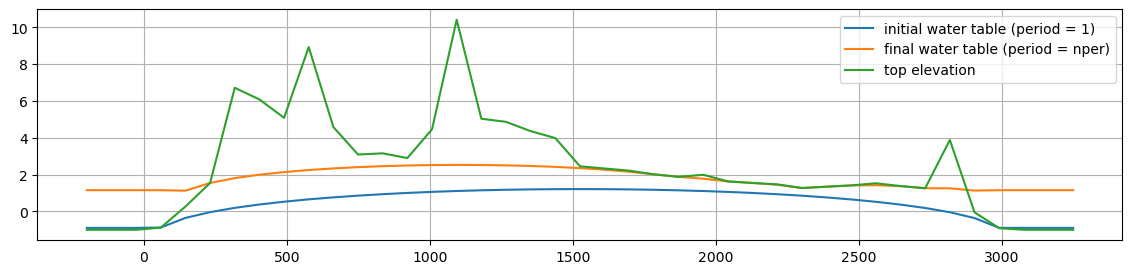

In [122]:
times = gwf.output.head().get_times()
head_first = gwf.output.head().get_data(totim=times[0])
head_last = gwf.output.head().get_data(totim=times[-1])
wt_first = flopy.utils.postprocessing.get_water_table(head_first)
wt_last = flopy.utils.postprocessing.get_water_table(head_last)

fig = plt.figure(figsize=(14,3))
plt.plot(xc, wt_first, label="initial water table (period = 1)")
plt.plot(xc, wt_last, label="final water table (period = nper)")
plt.plot(xc, top, label="top elevation")
plt.grid()
plt.legend()

In [123]:
# returns 'volume' in m^2 (volume per meter along the y-axis)
def get_potable_volume(zeta):
  potable_volume = 0.0
  for ilay in range(nlay):
    for icol in range(ncol):
        dz_fresh = topc[0, 0, icol] - zeta[0, 0, icol]
        vol = porosity * delr * 1.0 * dz_fresh
        potable_volume += vol
  return potable_volume

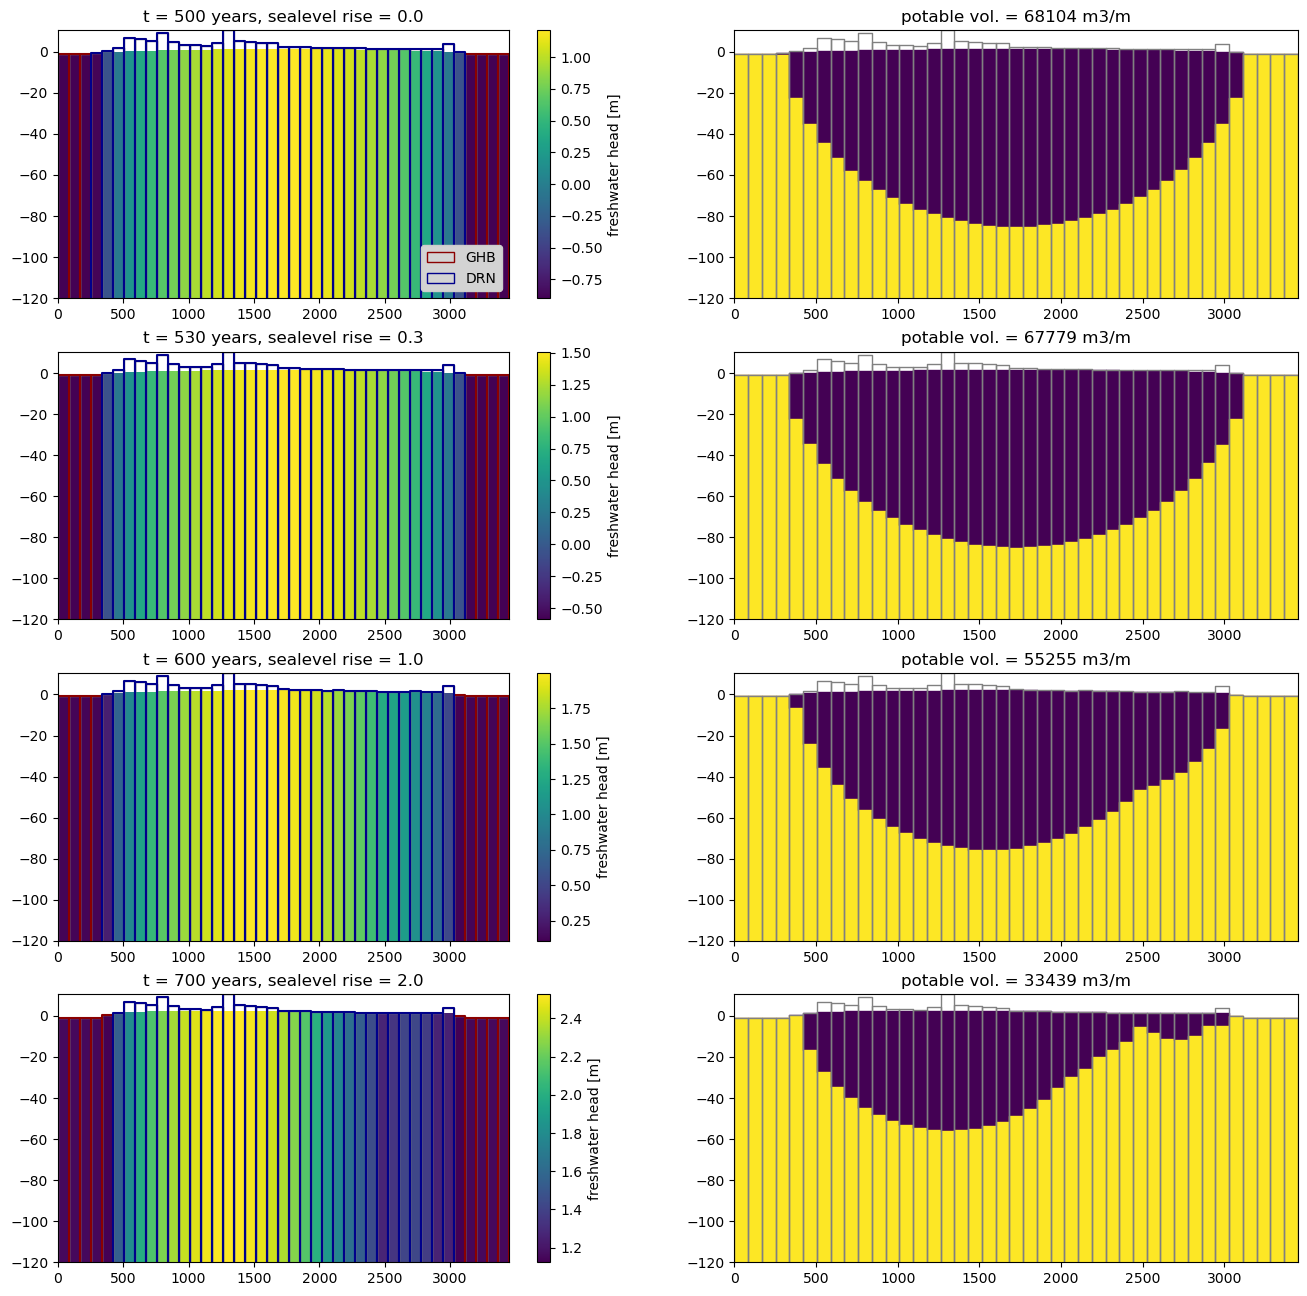

In [ ]:
plot_periods = [0, 3, int(nper/2), nper - 1]
nr_plots = len(plot_periods)

fig, axs = plt.subplots(len(plot_periods), 2, figsize=(16, 4 * nr_plots))
for idx, iper in enumerate(plot_periods):
  head = gwf.output.head().get_data(totim=times[iper])
  zeta = gwf.swi.output.zeta().get_data(totim=times[iper])

  # plot heads and location of boundary conditions
  ax = axs[idx, 0]
  t_yrs = int(0.1 + times[iper]/365.25)
  csl_m = get_sea_level(iper) - init_sealevel
  ax.set_title(f"t = {t_yrs} years, sealevel rise = {csl_m:.1f}")
  pxs = flopy.plot.PlotCrossSection(model=gwf, line={"row": 0}, ax=ax)
  pa = pxs.plot_array(head, head=head)
  pxs.plot_grid()
  pc_ghb = pxs.plot_bc("GHB", ec="darkred", fc='none', lw=1.5, label="GHB", kper=iper)
  pxs.plot_bc("DRN", ec="darkblue", fc='none', lw=1.5,label="DRN", kper=iper)
  handles = [Polygon([(0,0), (10,0), (0,-10)], fc='none', color="darkred", label="GHB"),
             Polygon([(0,0), (10,0), (0,-10)], fc='none', color="darkblue", label="DRN")]
  cb = plt.colorbar(pa)
  cb.set_label("freshwater head [m]")
  ax.set_ylim(-120,)
  if idx == 0:
    ax.legend(handles=handles, loc="lower right", facecolor='lightgrey', framealpha=1)

  # plot concentration and contours
  ax = axs[idx, 1]
  ax.set_title(f"potable vol. = {int(get_potable_volume(zeta))} m3/m")
  pxs = flopy.plot.PlotCrossSection(model=gwf, line={"row": 0}, ax=ax)

  # indigo and gold to replicate viridis
  colors = ['#440154', '#fde725']
  head = head.flatten()
  zeta = zeta.flatten()
  pxs.plot_fill_between(zeta, head=head, colors=colors, ax=ax, edgecolors="none")


#   pa = pxs.plot_array(conc, head=head)
#   nr_levels = 5
#   levels = np.linspace(conc_limit, conc_sea/2.0, nr_levels)
#   cs = pxs.contour_array(conc, levels=levels, cmap="Reds")
#   handles, labels = cs.legend_elements()

  pxs.plot_grid()
#   cb = plt.colorbar(pa)
#   cb.set_label("concentration [kg/m3]")
  ax.set_ylim(-120,)
#   if idx == 0:
#     ax.legend(handles, 
#                     [f"{levels[i]:.2f}" for i in range(nr_levels)], 
#                     loc='lower right',facecolor='lightgrey', framealpha=1)

In [125]:
zeta

array([ -1.        ,  -1.        ,  -1.        ,  -0.8837916 ,
         0.14967382, -16.56742189, -27.1310594 , -34.53866978,
       -40.21117655, -44.74205734, -48.2437206 , -51.00768055,
       -53.11152488, -54.60202682, -55.52279176, -55.88723237,
       -55.6839272 , -54.91810529, -53.56296716, -51.57881412,
       -48.88958838, -45.41683792, -40.99531104, -35.37646962,
       -30.0000905 , -25.86405065, -20.00121319, -16.63643919,
       -12.77052219,  -5.66984681,  -8.55652599, -11.27982222,
       -11.73166462,  -9.83156098,  -5.18671231,  -5.05341374,
        -0.06309194,  -0.9127054 ,  -1.        ,  -1.        ,
        -1.        ])

In [126]:
head

array([1.1525    , 1.1525    , 1.1525    , 1.14959479, 1.12375815,
       1.54168555, 1.80577649, 1.99096674, 2.13277941, 2.24605143,
       2.33359302, 2.40269201, 2.45528812, 2.49255067, 2.51556979,
       2.52468081, 2.51959818, 2.50045263, 2.46657418, 2.41697035,
       2.34973971, 2.26292095, 2.15238278, 2.01191174, 1.87750226,
       1.77410127, 1.62753033, 1.54341098, 1.44676305, 1.26924617,
       1.34141315, 1.40949556, 1.42079162, 1.37328902, 1.25716781,
       1.25383534, 1.1290773 , 1.15031763, 1.1525    , 1.1525    ,
       1.1525    ])